This notebook explores the real estate dataset from Kaggle: https://www.kaggle.com/datasets/quantbruce/real-estate-price-prediction?resource=download

In [1]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
import plotly.express as px
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

Import

In [2]:
# Read in CSV file downloaded from Kaggle
df = pd.read_csv(r"C:\Users\tiffa\Documents\Career\Real estate\Real estate_train.csv")

Wrangle

In [3]:
# Drop the 'No' column
df = df.drop(columns='No')

Explore

In [4]:
# Check columns
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     314 non-null    float64
 1   X2 house age                            314 non-null    float64
 2   X3 distance to the nearest MRT station  314 non-null    float64
 3   X4 number of convenience stores         314 non-null    int64  
 4   X5 latitude                             314 non-null    float64
 5   X6 longitude                            314 non-null    float64
 6   Y house price of unit area              314 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 17.3 KB


,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [5]:
fig = px.scatter_map(
    df,  # Our DataFrame
    lat="X5 latitude",
    lon="X6 longitude",
    width=600,  # Width of map
    height=600,  # Height of map
    color="Y house price of unit area",
    hover_data=["Y house price of unit area"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

We can see that the training data consists of properties near Taipei, Taiwan.  We can also see that all columns (1) have no missing values and (2) are not categorical.
There is also no leakage, i.e., features that would give the model information to which it won't have access when it's deployed.

<Axes: >

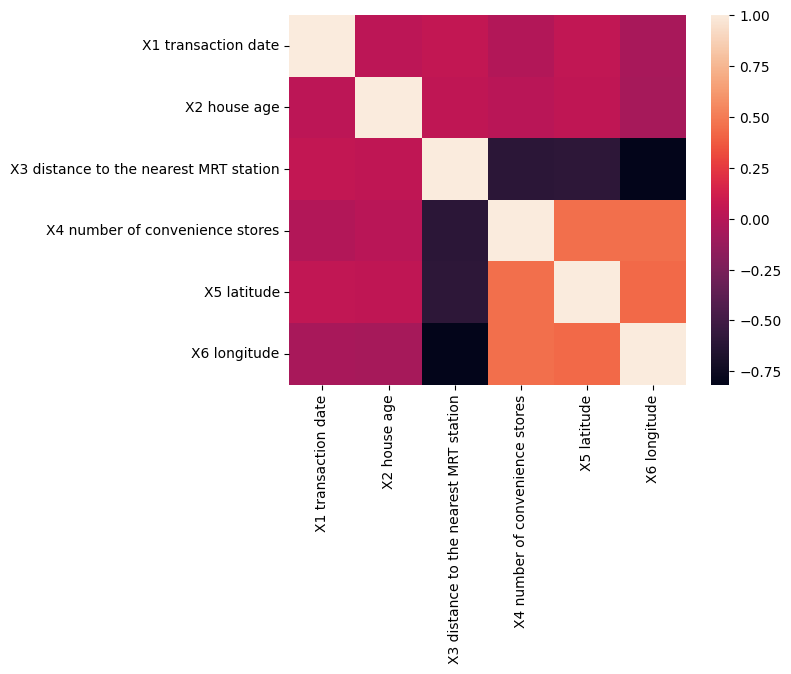

In [6]:
# Check for multicollinearity
corr = df.select_dtypes("number").drop(columns="Y house price of unit area").corr()
sns.heatmap(corr)

In [ ]:
# Drop features with multicollinearity
#df = df.drop(columns=["X1 transaction date", "X2 house age", "X4 number of convenience stores"])

# Check for multicollinearity
#corr = df.select_dtypes("number").drop(columns="Y house price of unit area").corr()
#sns.heatmap(corr)

Split Data

In [7]:
target = "Y house price of unit area"
features = ["X3 distance to the nearest MRT station", "X5 latitude", "X6 longitude", "X1 transaction date", "X2 house age", "X4 number of convenience stores"]
y_train = df[target]
X_train = df[features]

Build Model

In [8]:
# Calculate baseline
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

print("Mean property price:", round(y_mean, 2))
print("Baseline MAE:", round(mean_absolute_error(y_train, y_pred_baseline), 2))

Mean property price: 38.1
Baseline MAE: 11.0


Iterate

In [9]:
# Create pipeline.  Used ridge regression to prevent overfitting; features are highly correlated and small data set size
model = make_pipeline(
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('ridge', Ridge())])

Evaluate

In [10]:
# Predict y with X_train data
y_pred_training = model.predict(X_train)
print("Training MAE:", round(mean_absolute_error(y_train, y_pred_training), 2))

Training MAE: 6.55


Training MAE is lower than Baseline MAE.  The model is predicting well.
Iterated by keeping columns that were previously dropped for multicollinearity.  Ridge regression was effective in addressing multicollinearity without dropping columns.  Training MAE remains lower than Baseline MAE.

In [11]:
# Test model with test data

# Read in test data
X_test = pd.read_csv(r"C:\Users\tiffa\Documents\Career\Real estate\Real estate_test.csv").drop(columns=['No', 'Y house price of unit area'])

# Check feature sort orders
print("Training features:", X_train.columns.tolist())
print("Testing features:", X_test.columns.tolist())

Training features: ['X3 distance to the nearest MRT station', 'X5 latitude', 'X6 longitude', 'X1 transaction date', 'X2 house age', 'X4 number of convenience stores']
Testing features: ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']


In [12]:
# Features aren't in the same order so make X_test match X_train columns (both names and order)
X_test = X_test[X_train.columns]

# Check feature sort orders again
print("Training features:", X_train.columns.tolist())
print("Testing features:", X_test.columns.tolist())

Training features: ['X3 distance to the nearest MRT station', 'X5 latitude', 'X6 longitude', 'X1 transaction date', 'X2 house age', 'X4 number of convenience stores']
Testing features: ['X3 distance to the nearest MRT station', 'X5 latitude', 'X6 longitude', 'X1 transaction date', 'X2 house age', 'X4 number of convenience stores']


In [13]:
# Predict y with X_test data
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    47.621119
1    32.089529
2    48.080159
3    35.648612
4    53.451438
dtype: float64

In [14]:
# Evaluate predicted y with test data
y_test = pd.read_csv(r"C:\Users\tiffa\Documents\Career\Real estate\Real estate_test.csv")['Y house price of unit area']
print("Test MAE:", round(mean_absolute_error(y_test, y_pred_test), 2))

Test MAE: 5.91


Test was successful!  Test MAE is even lower than Training MAE.

Communicate Results

In [18]:
intercept = model.named_steps["ridge"].intercept_.round(0)
coefficients = model.named_steps["ridge"].coef_.round(0)
print(f"Intercept: {intercept}")
print("Coefficients:", coefficients)

Intercept: -11353.0
Coefficients: [-0.  8. -1.  6. -0.  1.]


In [19]:
# Deploy model in a function that returns model's prediction
def make_prediction( distance, lat, lon, date, house_age, number_stores):
    # Create a DataFrame with the features
    data = {
        "X3 distance to the nearest MRT station": [distance],
        "X5 latitude": [lat],
        "X6 longitude": [lon],
        "X1 transaction date": [date],
        "X2 house age": [house_age],
        "X4 number of convenience stores": [number_stores]
    }
    # Put data into a df
    df = pd.DataFrame(data, index=[0])
    # Use the model to make a prediction
    y_pred = model.predict(df).round(2)[0]
    # Print the prediction
    return f"Predicted price per unit area: ${y_pred}"

In [20]:
# Check that function works
make_prediction(84.87882, 24.98298, 121.54024, 2012.917, 32, 10)

'Predicted price per unit area: $46.07'

In [ ]:
# Deploy model in an interative widget
interact(
    make_prediction,
    distance=FloatSlider(
        value=X_train["X3 distance to the nearest MRT station"].mean(), 
        min=X_train["X3 distance to the nearest MRT station"].min(), 
        max=X_train["X3 distance to the nearest MRT station"].max(), 
        step=1
        ),
    lat=FloatSlider(
        value=X_train["X5 latitude"].mean(), 
        min=X_train["X5 latitude"].min(), 
        max=X_train["X5 latitude"].max(), 
        step=1
        ),
    lon=FloatSlider(
        value=X_train["X6 longitude"].mean(), 
        min=X_train["X6 longitude"].min(), 
        max=X_train["X6 longitude"].max(), 
        step=1
        ),
    date=FloatSlider(
        value=X_train["X1 transaction date"].mean(), 
        min=X_train["X1 transaction date"].min(), 
        max=X_train["X1 transaction date"].max(), 
        step=0.001
        ),
    house_age=IntSlider(
        value=X_train["X2 house age"].mean(), 
        min=X_train["X2 house age"].min(), 
        max=X_train["X2 house age"].max(), 
        step=1
        ),
    number_stores=IntSlider(
        value=X_train["X4 number of convenience stores"].mean(), 
        min=X_train["X4 number of convenience stores"].min(), 
        max=X_train["X4 number of convenience stores"].max(), 
        step=1
        )
);

interactive(children=(FloatSlider(value=1080.5541012101912, description='distance', max=6396.283, min=23.38284…